## Timeseries analysis of Stats NZ trade data

This notebook will examine the StatsNZ trade data between January 2014 and September 2022. The trade data contain values of NZ exports and imports for goods and services in NZ$. Exports and imports are listed per country and per 2-digits Harmonised System Classification codes.  

The table is available from the Stats NZ trade website: 
<a href='https://statisticsnz.shinyapps.io/trade_dashboard/'>Stats NZ Trade Dashboard</a>

#### 1. Data loading

In [1]:
#import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

#set plotting style and size
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16,6]

In [2]:
#read data into dataframe df
file = '../data/Tradedata.csv'

quarter_date_parser = lambda x: datetime.strptime(x, '%Y%m')
df = pd.read_csv(file, parse_dates=['Period'], date_parser=quarter_date_parser, index_col='Period')
df.index.rename('Quarter', inplace=True)
df.sort_values(by='Quarter', inplace=True)

In [3]:
#display dataframe
df.head(5)

,Country Code,Country,Account,Category,Code,Flag,Total Value (NZD),Description
Quarter,,,,,,,,
2014-06-01,AF,Afghanistan,Imports,Goods,00,F,131905.0,Total
2014-06-01,PT,Portugal,Imports,Goods,42,F,1471.0,Leather products
2014-06-01,PT,Portugal,Imports,Goods,44,F,378323.0,Wood
2014-06-01,PT,Portugal,Imports,Goods,45,F,361186.0,Cork
2014-06-01,PT,Portugal,Imports,Goods,48,F,142718.0,Paper products


#### 2. Data cleaning

The dataframe, df, contains 413815 rows and 8 columns plus one index column.
Data are collected between: 2014-06-01 and 2022-09-01

Values of NZ exports and imports are aggregated per quarters. The quarters are marked with the numbers: '03' - the first quarter, '06' - the second quarter, '09' - the third, and '12' - the fourth quarter

In [4]:
#information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413815 entries, 2014-06-01 to 2022-09-01
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Country Code       413179 non-null  object 
 1   Country            413751 non-null  object 
 2   Account            413815 non-null  object 
 3   Category           413815 non-null  object 
 4   Code               413815 non-null  object 
 5   Flag               413815 non-null  object 
 6   Total Value (NZD)  413815 non-null  float64
 7   Description        413815 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.4+ MB


The 'Country' column has 64 rows with missing country names and with the zero values for the exports and imports. Therefore these rows are removed from the dataframe. In addition all rows flagged as 'C' (confidential)  do not contain the trade values and can be removed from the data frame.    

In [5]:
# rows with zero trade values
print('Number of missing values, Country column:', df['Country'].isnull().sum())
print('Number of rows with zero trades:', df[df['Total Value (NZD)'] == 0].shape[0] )

Number of missing values, Country column: 64
Number of rows with zero trades: 30429


Removing the rows with the values of the Trades equal to zero

In [6]:
#filtering the data frame to exclude the confidential values
df1 = df[df['Total Value (NZD)'] != 0]
print('Number of rows with zero trades:', df1[df1['Total Value (NZD)'] == 0].shape[0] )


Number of rows with zero trades: 0


#### 3. Dataframe of exported and imported goods

The input data file contains two types of trades: goods and services. The trades, goods or services can be Imported or Exported from New Zealand. 

In [7]:
#create dataframes for exported and imported goods

goods_exports= df1[(df1['Account']=='Exports') & (df1['Category']=='Goods') ]
goods_imports= df1[(df1['Account']=='Imports') & (df1['Category']=='Goods') ]

#size of dataframes
print('Exports of goods dataframe:', goods_exports.shape, 'Imports of goods dataframe:', goods_imports.shape)

Exports of goods dataframe: (164196, 8) Imports of goods dataframe: (185076, 8)


Exported and imported products are labeled as two-digit codes, where the code '00' represents the total values of all exported and imported products per country 

In [8]:
#find number of unique codes 

print('Number of unique codes for exported and imported products:', goods_exports[goods_exports['Code']!='00']['Code'].nunique(),',', goods_imports[goods_imports['Code']!='00']['Code'].nunique())

Number of unique codes for exported and imported products: 97 , 97


In [9]:
#find number of countries where products are exported or imported 
countries_perquarter_exp = goods_exports.groupby('Quarter')['Country'].nunique()
countries_perquarter_imp = goods_imports.groupby('Quarter')['Country'].nunique()

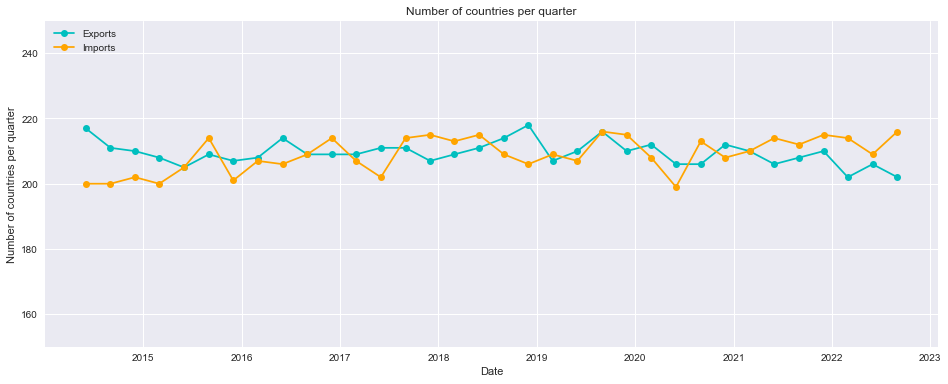

In [10]:
#plot number of countries per quarter
fig,ax = plt.subplots()
line1=ax.plot(countries_perquarter_exp.index, countries_perquarter_exp.values, color = 'c', marker='o',label='Exports')
line2=ax.plot(countries_perquarter_imp.index, countries_perquarter_imp.values, color = 'orange', marker='o', label='Imports')

ax.set_xlabel('Date')
ax.set_title('Number of countries per quarter')
ax.set_ylabel('Number of countries per quarter')
plt.ylim(150,250)
plt.legend(loc='upper left')
plt.show()

#### 4. Total exports and imports

In [11]:
#total exports and imports per country
goods_exports_country_total = df[(df['Account']=='Exports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]
goods_imports_country_total = df[(df['Account']=='Imports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]

#subset dataframes
goods_exports_country_total = goods_exports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]
goods_imports_country_total = goods_imports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]

#transform and rename columns 
goods_exports_country_total['Total Value (NZD)'] = round(goods_exports_country_total['Total Value (NZD)'].div(1000),2)   
goods_exports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

goods_imports_country_total['Total Value (NZD)'] = round(goods_imports_country_total['Total Value (NZD)'].div(1000),2)   
goods_imports_country_total.rename(columns={'Country Code':'CountryCode', 'Total Value (NZD)':'ValuesInThousandsNZD'}, inplace = True)   

In [12]:
#total exports and imports for all countries
goods_exports_total = df[(df['Account']=='Exports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]
goods_imports_total = df[(df['Account']=='Imports') & (df['Category']=='Goods')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]

#values of exports and imports in billions $NZ
goods_exports_total = goods_exports_total[['Total Value (NZD)']]
goods_exports_total['Total Value (NZD)'] = round(goods_exports_total['Total Value (NZD)'].div(1000000000),2)
goods_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

goods_imports_total = goods_imports_total[['Total Value (NZD)']]
goods_imports_total['Total Value (NZD)'] = round(goods_imports_total['Total Value (NZD)'].div(1000000000),2)
goods_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

#### 5. Dataframe of exported and imported services

In [13]:
#create dataframe of services
services_exports= df[(df['Account']=='Exports') & (df['Category']=='Services') ]
services_imports= df[(df['Account']=='Imports') & (df['Category']=='Services') ]

#size of dataframes
print('Exports of services dataframe:', services_exports.shape, 'Imports of services dataframe:', services_imports.shape)

Exports of services dataframe: (35756, 8) Imports of services dataframe: (28787, 8)


In [14]:
print('Time interval for Services: between' , services_exports.index.min(), 'quarter and ', services_exports.index.max(), 'quarter')

Time interval for Services: between 2014-06-01 00:00:00 quarter and  2022-09-01 00:00:00 quarter


Exported and imported services are labeled as two and four digits A codes. 

In [15]:
#number of countries for each code 

services_exp = services_exports.groupby('Code')['Country'].nunique()
services_imp = services_imports.groupby('Code')['Country'].nunique()
print(pd.merge(services_exp, services_imp, left_on=services_exp.index, right_on=services_imp.index, how='left'))

    key_0  Country_x  Country_y
0     A12        242        240
1   A1202         60         67
2   A1203         61         64
3   A1204        241        234
4   A1205         61         65
5   A1206         54         49
6   A1207        150         74
7   A1208        163        123
8   A1209        178        174
9   A1210        212        210
10  A1211        164        121
11  A1212        234         49


In [16]:
#total exports and imports per country
services_exports_country_total = df[(df['Account']=='Exports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]
services_imports_country_total = df[(df['Account']=='Imports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']!='Total all countries')]

#subseting dataframes
services_exports_country_total = services_exports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]
services_imports_country_total = services_imports_country_total[['Country Code', 'Country', 'Total Value (NZD)']]

In [17]:
print(services_exports_country_total)

           Country Code                                    Country  \
Quarter                                                              
2014-06-01           PL                                     Poland   
2014-06-01           PN                                   Pitcairn   
2014-06-01           RE                                    Reunion   
2014-06-01           RO                                    Romania   
2014-06-01           PR                                Puerto Rico   
...                 ...                                        ...   
2022-09-01           GN                                     Guinea   
2022-09-01           GU                                       Guam   
2022-09-01           GP                                 Guadeloupe   
2022-09-01           GT                                  Guatemala   
2022-09-01           HK  Hong Kong (Special Administrative Region)   

            Total Value (NZD)  
Quarter                        
2014-06-01          18937

In [18]:
#total exports and imports per quarters for all countries

services_exports_total = df[(df['Account']=='Exports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]
services_imports_total = df[(df['Account']=='Imports') & (df['Category']=='Services')  & (df['Description']=='Total') & (df['Country']=='Total all countries')]

#values of exports and imports in billions $NZ
services_exports_total = services_exports_total[['Total Value (NZD)']]
services_exports_total['Total Value (NZD)'] = round(services_exports_total['Total Value (NZD)'].div(1000000000),2)
services_exports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

services_imports_total = services_imports_total[['Total Value (NZD)']]
services_imports_total['Total Value (NZD)'] = round(services_imports_total['Total Value (NZD)'].div(1000000000),2)
services_imports_total.rename(columns={'Total Value (NZD)':'ValuesInBillionsNZD'}, inplace = True) 

#### 6. Values of total exports and imports

In [19]:
#Total trades including goods and services
total_trade_exports=services_exports_total.merge(goods_exports_total, left_index=True, right_index=True)
total_trade_imports=services_imports_total.merge(goods_imports_total, left_index=True, right_index=True)

total_trade_exports['ValueOfGoodsandServices'] = total_trade_exports['ValuesInBillionsNZD_x']+ total_trade_exports['ValuesInBillionsNZD_y']
total_trade_imports['ValueOfGoodsandServices'] = total_trade_imports['ValuesInBillionsNZD_x']+ total_trade_imports['ValuesInBillionsNZD_y']

#### 7. Graph of total exports and imports 

The following graph presents the values of exports and imports for Goods and Services and values of the total trades (goods + services).

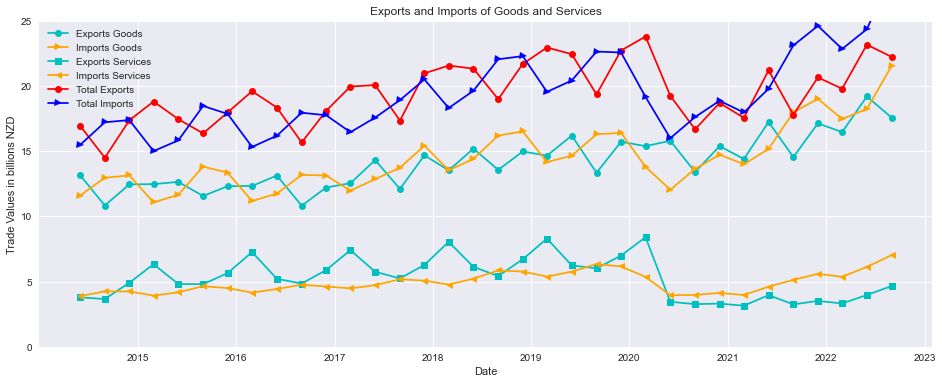

In [20]:
fig,ax = plt.subplots()

line1 = ax.plot(goods_exports_total.index, goods_exports_total.values, color = 'c', marker='o',label='Exports Goods')
line2 = ax.plot(goods_imports_total.index, goods_imports_total.values, color = 'orange', marker='>', label='Imports Goods')
line3 = ax.plot(services_exports_total.index, services_exports_total.values, color = 'c', marker='s',label='Exports Services')
line4 = ax.plot(services_imports_total.index, services_imports_total.values, color = 'orange', marker='<', label='Imports Services')

line5 = ax.plot(total_trade_exports.index, total_trade_exports.ValueOfGoodsandServices, color = 'red', marker='o', label='Total Exports')
line6 = ax.plot(total_trade_imports.index, total_trade_imports.ValueOfGoodsandServices, color = 'blue', marker='>', label='Total Imports')

ax.set_xlabel('Date')
ax.set_title('Exports and Imports of Goods and Services')
ax.set_ylabel('Trade Values in billions NZD')
plt.ylim(0,25)
plt.legend(loc = 'upper left')
plt.show()

#### 8. Exports per countries - Goods

In [21]:
#maximum exports per quarter and per country

df3 = goods_exports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df4 = df3.sort_values('ValuesInThousandsNZD', ascending = 0)

In [22]:
#pivot the table by countries and sort from max to min

goods_exports_country_total_pivot = pd.pivot_table(goods_exports_country_total,
                                    values='ValuesInThousandsNZD',
                                    index='Quarter',
                                    columns='Country',
                                    aggfunc=np.mean)

In [23]:
#Countries with the maximum exports 
df_temp = goods_exports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 

for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm 

#dfm_export_goods = dfm.iloc[16:6,]
#dfm_export_goods = dfm.loc['20190301' : '20201201']
#dfm_export_goods.index = dfm_export_goods.index.strftime('%Y-%m-%d')
#print (dfm_export_goods.head(5))

In [24]:
#Resampling to values of the good exports per Year

df_export_perYear = df_row.resample("Y"). sum() 
df_export_perYear.index.rename('Year', inplace=True)
df_export_perYear.index = df_export_perYear.index.strftime('%Y')

print(df_export_perYear.head(5))

Country   Australia  China, People's Republic of  United States of America  \
Year                                                                         
2014     4541222.89                   4069436.39                2333029.80   
2015     8339522.92                   8611422.68                5757781.15   
2016     8277020.16                   9432047.60                5298580.47   
2017     8807782.04                  12094098.59                5324927.94   
2018     9063086.10                  13847432.01                5501167.26   

Country       Japan  Korea, Republic of  Indonesia  
Year                                                
2014     1427776.75           905950.40        0.0  
2015     2952502.96           418224.12        0.0  
2016     2974982.66           692047.11        0.0  
2017     3205408.47           792611.44        0.0  
2018     3493899.41          1744697.07        0.0  


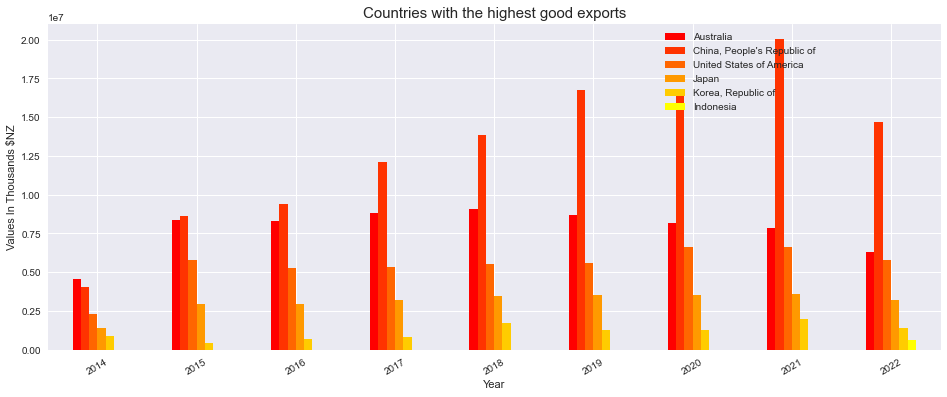

In [25]:
#Countries with the highest values of good exports between 2014 and 2022

color_map=plt.cm.get_cmap('autumn')

ax = df_export_perYear.plot(kind='bar', cmap = color_map) 

plt.xticks(rotation=30, horizontalalignment='center')
ax.set_title('Countries with the highest good exports', fontsize=15)
ax.set_ylabel('Values In Thousands $NZ')
#ax.set_xlim(2015,2022)
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()

#### 9. Imports per countries - Goods

In [26]:
#maximum imports per quarter and per country

df1 = goods_imports_country_total.groupby(['Quarter', 'Country']).agg({'ValuesInThousandsNZD': sum})
df2 = df1.sort_values('ValuesInThousandsNZD', ascending = 0)

In [27]:
#pivot the table by countries and sort from max to min

goods_imports_country_total_pivot = pd.pivot_table(goods_imports_country_total,
                                    values='ValuesInThousandsNZD',
                                    index='Quarter',
                                    columns='Country',
                                    aggfunc=np.mean)

In [28]:
#Countries with the maximum imports 
df_temp = goods_imports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 


for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm
    
#dfm_export_goods = dfm.iloc[16:6,]
#dfm_import_goods = dfm.loc['20190301' : '20201201']
#dfm_import_goods.index = dfm_import_goods.index.strftime('%Y-%m-%d')
#print (dfm_import_goods.head(5))

In [29]:
#Resampling to values of good imports per Year

df_import_perYear = df_row.resample("Y"). sum() 
df_import_perYear.index.rename('Year', inplace=True)
df_import_perYear.index = df_import_perYear.index.strftime('%Y')

print(df_import_perYear.head(5))

Country  China, People's Republic of  United States of America   Australia  \
Year                                                                         
2014                      4662841.94                3319151.80  3292469.94   
2015                      9883514.86                5891415.80  5952382.72   
2016                      9957539.15                5573594.12  6220759.03   
2017                     10536296.29                5760941.14  6641390.48   
2018                     12076149.26                6107054.99  7006301.54   

Country       Japan     Germany  Singapore  
Year                                        
2014     1616990.33  1252916.14        0.0  
2015     3143949.18  2335192.03        0.0  
2016     3382375.24  1796056.99        0.0  
2017     3864148.16  2283650.89        0.0  
2018     4112662.95        0.00        0.0  


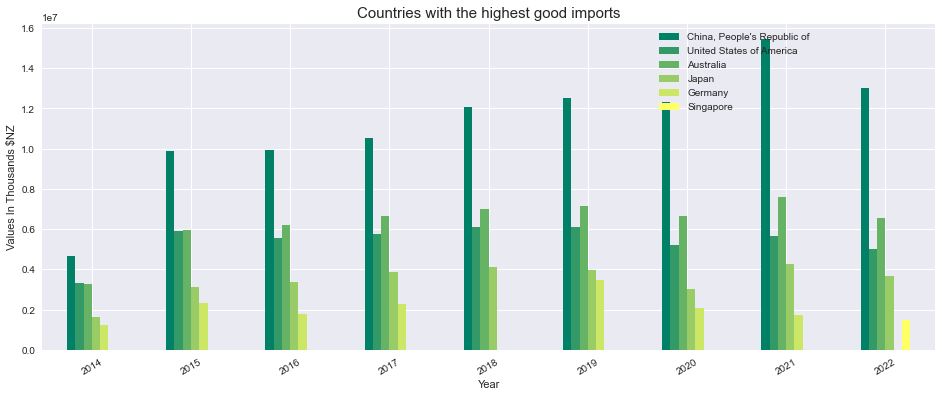

In [30]:
#Countries with the highest values of good imports between 2015 and 2022

color_map=plt.cm.get_cmap('summer')

ax = df_import_perYear.plot(kind='bar', cmap = color_map) 

plt.xticks(rotation=30, horizontalalignment='center')
ax.set_title('Countries with the highest good imports', fontsize=15)
ax.set_ylabel('Values In Thousands $NZ')
#ax.set_xlim(2015,2022)
ax.legend(loc='upper right', bbox_to_anchor=(0.87,1.0))
plt.show()

#### 10. Exports per countries - Services

In [31]:
#maximum exports per quarter and per country

dfs1 = services_exports_country_total.groupby(['Quarter', 'Country']).agg({'Total Value (NZD)': sum})
dfs2 = dfs1.sort_values('Total Value (NZD)', ascending = 0)

In [32]:
#pivot the table by countries and sort from max to min

services_exports_country_total_pivot = pd.pivot_table(services_exports_country_total,
                                    values='Total Value (NZD)',
                                    index='Quarter',
                                    columns='Country',
                                    aggfunc=np.mean)

In [33]:
#Countries with the maximum exports 
df_temp = services_exports_country_total_pivot
df_row = df_temp[df_temp.index == df_temp.index[1]].sort_values(by = df_temp.index[1], axis = 1, ascending = False) 

for i in range(2, len(df_temp.index)):
    df_row1 = df_temp[df_temp.index == df_temp.index[i]].sort_values(by = df_temp.index[i], axis = 1, ascending = False)
    dfm = df_row.iloc[:,0:5].append(df_row1.iloc[:,0:5])
    df_row = dfm

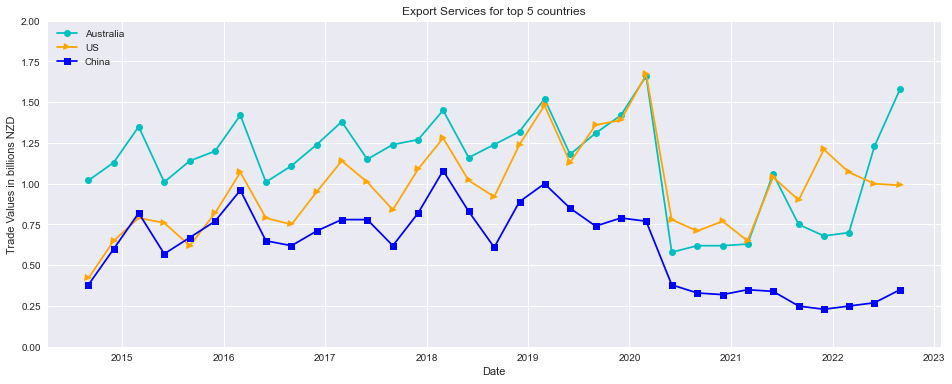

In [34]:
fig,ax = plt.subplots()

line1 = ax.plot(df_row.index, (df_row.iloc[:,0]/1000000000).round(2).values, color = 'c', marker='o', label='Australia')
line2 = ax.plot(df_row.index, (df_row.iloc[:,1]/1000000000).round(2).values, color = 'orange', marker='>', label='US')
line3 = ax.plot(df_row.index, (df_row.iloc[:,2]/1000000000).round(2).values, color = 'blue', marker='s', label='China')
ax.set_xlabel('Date')
ax.set_title('Export Services for top 5 countries')
ax.set_ylabel('Trade Values in billions NZD')
plt.ylim(0,2)
plt.legend(loc = 'upper left')
plt.show()

#### 11. Imports per countries - Services